In [15]:
import networkx as nx
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Optional

import sys
import algo.board
sys.modules['board'] = algo.board
from algo.board import Board, GameState

In [2]:
OUR_SIGN = -1

@dataclass
class LeafData:
	depth: int
	board_bytes: bytes
	game_state: GameState
	turn_sign: int
	parent_bytes: Optional[bytes]
	children_bytes: Optional[list[bytes]]
	stats: dict[bool, int]
	completed: bool

	def __post_init__(self):
		self.__value = None
		self.__hash = None

	def __compute_int(self):
		ret = 0
		board = Board.from_num_repr(self.board_bytes)
		for _, piece in board:
			ret += piece * OUR_SIGN
		
		ret *= 5
		ret += self.depth // (board.moves_since_last_capture + 1)

		if board.turn_sign != OUR_SIGN:
			ret = -ret

		del board
		return ret
	
	@property
	def value(self) -> int:
		if not self.__value:
			self.__value = self.__compute_int()
		return self.__value
	
	def __hash__(self) -> int:
		if not self.__hash:
			self.__hash = hash(self.board_bytes)
		return self.__hash

In [3]:
import pickle

with open("tree.pickle", "rb") as f:
	lead_data = pickle.load(f)

In [4]:
leaf_data = lead_data
len(leaf_data)

20731

In [5]:
root = next(iter(leaf_data.values()))

In [6]:
root

LeafData(depth=0, board_bytes=b'\x01\x00\x01\x00\x00\x01\x01\x01\x01\x01\x01\x02\x02\x02\x02\x02\x02\x03\x03\x03\x03\x03\x03', game_state=<GameState.NOT_OVER: 0>, turn_sign=1, parent_bytes=None, children_bytes=[b'\x01\x01\x00\x00\x00\x01\x01\x01\x01\x01\x01\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x03', b'\x01\x01\x00\x00\x00\x01\x01\x01\x01\x01\x01\x02\x02\x02\x03\x02\x02\x03\x02\x03\x03\x03\x03', b'\x01\x01\x00\x00\x00\x01\x01\x01\x01\x01\x01\x02\x02\x02\x02\x03\x02\x03\x02\x03\x03\x03\x03', b'\x01\x01\x00\x00\x00\x01\x01\x01\x01\x01\x01\x02\x02\x02\x02\x03\x02\x03\x03\x02\x03\x03\x03', b'\x01\x01\x00\x00\x00\x01\x01\x01\x01\x01\x01\x02\x02\x02\x02\x02\x03\x03\x03\x02\x03\x03\x03'], stats={False: 87, True: 15}, completed=False)

In [154]:
min_value = min(leaf.value for leaf in leaf_data.values())

In [155]:
min_value

-40

In [156]:
G = nx.Graph()

i = 0

q: list[LeafData] = [root]

no_parent = 0

while q:
	i += 1
	node = q.pop()
	
	if node.parent_bytes and node.parent_bytes not in G.nodes:
		continue

	G.add_node(
		node.board_bytes,
		value=node.value - min_value,
		depth=node.depth,
		wins=node.stats[True],
		games=node.stats[False] + node.stats[True],
	)

	if node.parent_bytes:
		G.add_edge(node.parent_bytes, node.board_bytes)

	if node.children_bytes:
		for child_bytes in node.children_bytes:
			if child_bytes not in leaf_data:
				continue

			child = leaf_data[child_bytes]
			q.append(child)

In [157]:
len(G.nodes)

19934

In [158]:
pos = nx.nx_agraph.graphviz_layout(G, prog="dot", root=root.board_bytes)

In [159]:
max(v[0] for v in pos.values()), min(v[0] for v in pos.values())

(3150800.0, 336.43)

In [160]:
max(v[1] for v in pos.values()), min(v[1] for v in pos.values())

(2006.0, 18.0)

In [161]:
new_pos = {
    k: (
        (v[0] - 336) * 40e3 / 3150800,
        (v[1] - 17) * 1.5e3 / 2006,
	)
    for k, v in pos.items()
}

In [162]:
nx.set_node_attributes(G, {node: new_pos[node][0] for node in G.nodes}, "x")
nx.set_node_attributes(G, {node: new_pos[node][1] for node in G.nodes}, "y")

In [163]:
for node in G.nodes:
    print(G.nodes[node])
    break

{'value': 40, 'depth': 0, 'wins': 15, 'games': 102, 'x': 4131.192078202362, 'y': 1487.2881355932204}


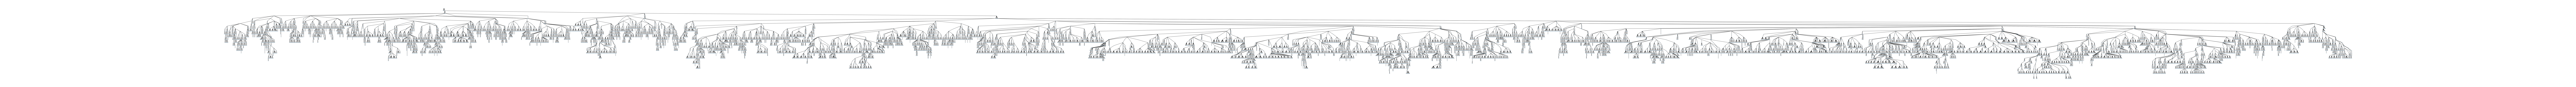

In [164]:
plt.figure(figsize=(300, 10))
nx.draw(G, pos, node_size=1, font_size=5, labels=nx.get_node_attributes(G, 'stats'))
plt.savefig("tree.png", transparent=True)
plt.show()

In [165]:
G_c = nx.relabel_nodes(G, lambda x: x.hex())

In [166]:
for node in G_c.nodes:
    print(node)
    print(G_c.nodes[node])
    break

0100010000010101010101020202020202030303030303
{'value': 40, 'depth': 0, 'wins': 15, 'games': 102, 'x': 4131.192078202362, 'y': 1487.2881355932204}


In [167]:
nx.write_gml(G_c, "tree.gml")